# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.feather`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import *


import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Load time series data

In [2]:
# Read time series data from the binary file that clean_us_data.ipynb produces
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
cases = pd.read_feather(cases_file).set_index("FIPS")
dates = pd.read_feather(dates_file)["date"].to_numpy()
cases.head()

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,370,5
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,996,6
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,82,1
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,132,-1
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,262,8


In [3]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

## Aliasing in time series for sparsely-populated counties

Because these time series are integer-valued, there can be problems with aliasing. 
Here are some examples of what aliasing looks like (The `graph_examples()` function is defined in [util.py](./util.py))

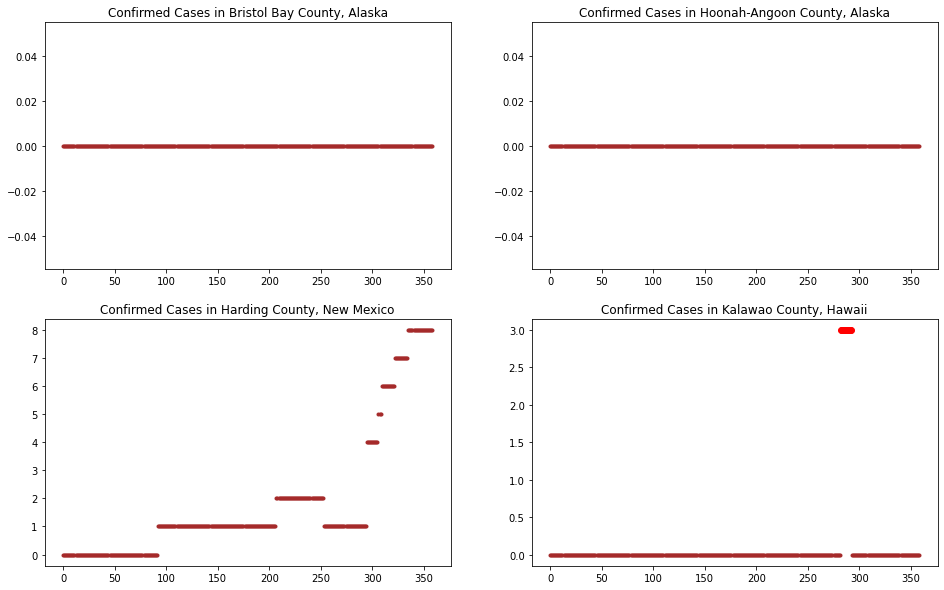

In [4]:
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].array, axis=1) < 10))

## Filter time series that are subject to aliasing

To avoid problems due to aliasing, we will restrict the analysis
in the rest of this notebook to time series whose maximum values
go above a threshold.

In [5]:

alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].array, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].array, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].array[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].array[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorDtype):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,370,5
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,996,6
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,82,1
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,132,-1
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,262,8
...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,142,2
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,319,0
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,126,1


# Warm-up: Fit a straight line

We use sklearn's implementation of [BGFS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) as the optimizer.

First we fire up [Ray](https://ray.io/) so that we can fit multiple curves at the same time.

In [6]:
import ray
if not ray.is_initialized():
    ray.init()

2021-01-15 13:47:58,196	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8266


In [7]:
# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].array.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

# Fit all the curves in parallel
@ray.remote
def fit_line(points: np.array):
    return scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(points), bounds=linear_bounds)
futures = [fit_line.remote(ts) for ts in series_values]

# Wrap results in a DataFrame
linear = filtered[metadata_cols].copy()
linear["Result_Object"] = ray.get(futures)
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,"{'fun': 66568313.084427975, 'jac': [0.74505799...",11.795221,-311.000000,[-311. -299.2047792 -287.4095584 -275...,0.876144
1003,Alabama,Baldwin,223234,996,6,"{'fun': 1079029029.8583224, 'jac': [0.0, 37493...",33.677694,-311.000000,[-3.11000000e+02 -2.77322306e+02 -2.43644611e+0...,0.812874
1005,Alabama,Barbour,24686,82,1,"{'fun': 1475349.8850269062, 'jac': [-0.1396983...",5.433394,-204.616550,[-204.61654972 -199.18315614 -193.74976256 -188...,0.980453
1007,Alabama,Bibb,22394,132,-1,"{'fun': 12465671.651542451, 'jac': [-0.1862645...",5.723484,-311.000000,[-311. -305.27651642 -299.55303283 -293...,0.874115
1009,Alabama,Blount,57826,262,8,"{'fun': 130361899.30666164, 'jac': [-4.4703479...",11.866998,-311.000000,[-3.11000000e+02 -2.99133002e+02 -2.87266005e+0...,0.804576
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,"{'fun': 108347273.98546332, 'jac': [0.0, 53860...",6.604666,-311.000000,[-3.11000000e+02 -3.04395334e+02 -2.97790669e+0...,0.599455
56039,Wyoming,Teton,23464,319,0,"{'fun': 33687671.799771816, 'jac': [0.0, 20070...",6.177872,-311.000000,[-311. -304.8221277 -298.6442554 -292...,0.772768
56041,Wyoming,Uinta,20226,126,1,"{'fun': 17750884.577707425, 'jac': [0.0, 1309....",4.691149,-311.000000,[-311. -306.30885136 -301.61770271 -296...,0.759687


## Graph: Example linear curves

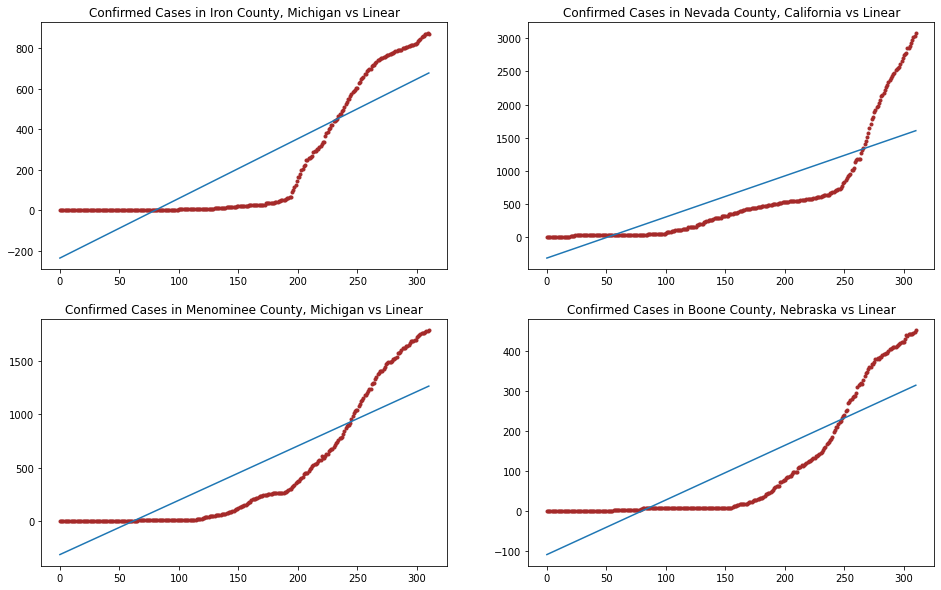

In [8]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

# Define code for fitting any curve

As you can see from the above graphs, straight lines do not explain the data in most of these time series.
Let's fit some more appropriate curves to this data, using the same BGFS optimizer.
First, we'll break out the repetitive parts of the curve-fitting process into a Python function.

In [9]:
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].array.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    # Fit the curve to all time series in parallel
    @ray.remote
    def fit_curve(points: np.array):
        return scipy.optimize.minimize(
            objective, initial_guess,
            args=(points), bounds=bounds)
    futures = [fit_curve.remote(ts) for ts in series_values]
    
    # Wrap the results in a DataFrame
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = ray.get(futures)
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [10]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate * (X - offset))
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.001, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curves to each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


# Fit exponential curves

In [11]:
%%time
exp_df = fit_exponential(ts_col_name)
exp_df

CPU times: user 5.9 s, sys: 835 ms, total: 6.74 s
Wall time: 17.3 s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,"{'fun': 254756012.59520283, 'jac': [-11017.918...",0.028498,0.0,[1.00000000e+00 1.02890810e+00 1.05865188e+00 1...,0.526005
1003,Alabama,Baldwin,223234,996,6,"{'fun': 2961232758.4436784, 'jac': [892686.843...",0.032339,0.0,[1.00000000e+00 1.03286738e+00 1.06681502e+00 1...,0.486461
1005,Alabama,Barbour,24686,82,1,"{'fun': 65685020.72039889, 'jac': [-6566.94173...",0.025220,0.0,[1.00000000e+00 1.02554080e+00 1.05173394e+00 1...,0.129727
1007,Alabama,Bibb,22394,132,-1,"{'fun': 30449835.4265053, 'jac': [-870.2278135...",0.025642,0.0,[1.00000000e+00 1.02597395e+00 1.05262255e+00 1...,0.692501
1009,Alabama,Blount,57826,262,8,"{'fun': 216146019.2781301, 'jac': [2291.798591...",0.028733,0.0,[1.00000000e+00 1.02915025e+00 1.05915024e+00 1...,0.675977
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,"{'fun': 19536225.893804204, 'jac': [-0.7450580...",0.027048,0.0,[1.00000000e+00 1.02741758e+00 1.05558688e+00 1...,0.927777
56039,Wyoming,Teton,23464,319,0,"{'fun': 28803792.9625488, 'jac': [5668.7742462...",0.026235,0.0,[1.00000000e+00 1.02658197e+00 1.05387055e+00 1...,0.805711
56041,Wyoming,Uinta,20226,126,1,"{'fun': 10046156.521434069, 'jac': [-1.4901161...",0.025038,0.0,[1.00000000e+00 1.02535454e+00 1.05135193e+00 1...,0.863994


## Graph: Example exponential curves

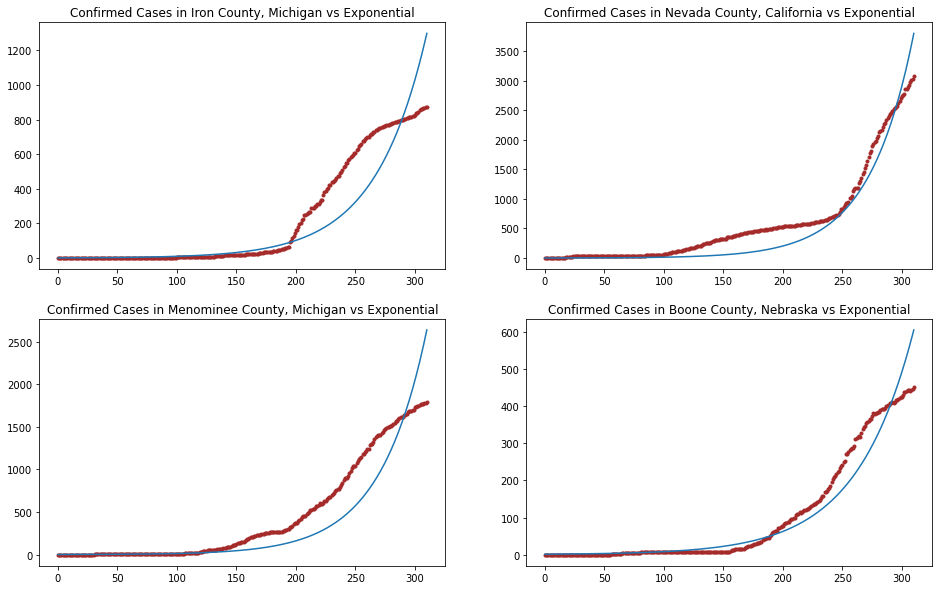

In [12]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

# Fit logistic curves

The [logistic function](https://en.wikipedia.org/wiki/Logistic_function) produces an "S"-shaped curve 
that often closely matches one wave of a disease outbreak.

In [13]:
%%time
log_df = fit_logistic(ts_col_name)
log_df

CPU times: user 6.28 s, sys: 989 ms, total: 7.27 s
Wall time: 30.4 s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,"{'fun': 12759316.063357994, 'jac': [0.37249909...",9081.729294,0.013844,311.000000,[ 120.93651921 122.59959556 124.28522475 125...,0.976260
1003,Alabama,Baldwin,223234,996,6,"{'fun': 147513358.1729362, 'jac': [5.959985449...",29503.984866,0.014623,311.000000,[ 309.19229746 313.69843924 318.2695372 ...,0.974418
1005,Alabama,Barbour,24686,82,1,"{'fun': 1789032.1878478343, 'jac': [-0.0232833...",1619.102393,0.017807,190.093143,[ 53.05046486 53.97184563 54.90866787 55...,0.976297
1007,Alabama,Bibb,22394,132,-1,"{'fun': 1646527.699262028, 'jac': [0.069849931...",3954.603645,0.015124,311.000000,[ 35.51783827 36.05415977 36.59850412 37...,0.983372
1009,Alabama,Blount,57826,262,8,"{'fun': 494888622.6827295, 'jac': [1215.947612...",2025.916177,0.008293,2.282522,[1003.37136413 1007.57131097 1011.77144304 1015...,0.258117
...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,"{'fun': 4994310.9872464975, 'jac': [-0.0931332...",4149.256730,0.039796,272.368290,[8.13951787e-02 8.46996110e-02 8.81381918e-02 9...,0.981537
56039,Wyoming,Teton,23464,319,0,"{'fun': 1748183.8503318357, 'jac': [0.02328331...",5066.600942,0.018565,311.000000,[ 15.69913956 15.99238784 16.29109612 16...,0.988208
56041,Wyoming,Uinta,20226,126,1,"{'fun': 2002498.9610930146, 'jac': [0.04656662...",3619.410957,0.019954,311.000000,[ 7.28969896 7.43631418 7.58587202 7...,0.972890


## Graph: Example logistic curves

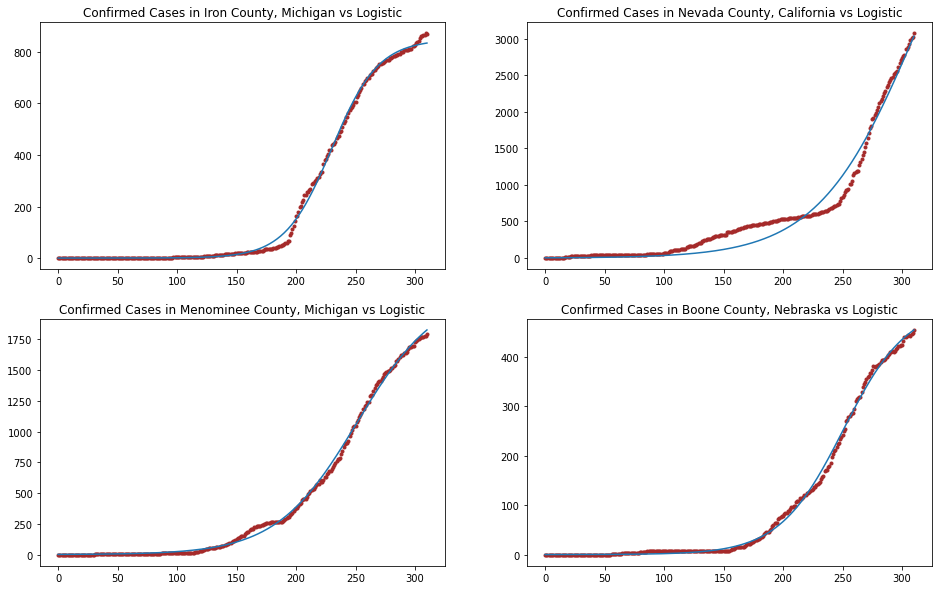

In [14]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

# Fit a mixture of two logistic curves

A mixture of two logistic curves with different starting points can explain the data for disease
outbreaks involving two distinct waves.

In [15]:
%%time
log2_df = fit_logistic2(ts_col_name)
log2_df

(pid=67310) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67310)   required=False,
(pid=67306) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67306)   required=False,
(pid=67308) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67308)   required=False,


(pid=67312) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67312)   required=False,
(pid=67312) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67312)   type=str,
(pid=67313) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67313)   required=False,


(pid=67307) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67307)   required=False,
(pid=67309) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67309)   required=False,


(pid=67311) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:55: RuntimeWarning: overflow encountered in exp
(pid=67311)   required=False,


(pid=67310) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67310)   type=str,


(pid=67307) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67307)   type=str,


(pid=67308) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67308)   type=str,


(pid=67313) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67313)   type=str,


(pid=67309) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67309)   type=str,


(pid=67311) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67311)   type=str,


(pid=67306) /Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ray/workers/default_worker.py:56: RuntimeWarning: overflow encountered in exp
(pid=67306)   type=str,


/Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
/Users/freiss/pd/cn-ray/env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


CPU times: user 10.7 s, sys: 2.44 s, total: 13.1 s
Wall time: 2min 43s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,"{'fun': 17964697.230940744, 'jac': [10243.0500...",957.512879,0.008021,18.742610,12051.465616,0.014809,310.373782,30.037952,300.858108,[ 292.32195481 293.87362835 295.43774197 297...,0.966575
1003,Alabama,Baldwin,223234,996,6,"{'fun': 122628582.8302601, 'jac': [-29528.1175...",607.107601,1.890114,128.061738,40565.177296,0.013531,311.000000,55.766579,311.000000,[ 261.45849414 265.54916839 269.70210067 ...,0.978734
1005,Alabama,Barbour,24686,82,1,"{'fun': 3898073.6534909373, 'jac': [2716.88294...",1342.659211,0.000000,0.000000,1450.216033,0.020795,174.553240,0.000000,4.629637,[ 535.15051762 510.83516795 483.84483444 454...,0.948354
1007,Alabama,Bibb,22394,132,-1,"{'fun': 71456.04612428666, 'jac': [0.346339245...",3796.743247,0.041013,153.445154,4166.904485,0.024963,311.000000,0.000000,105.055739,[ 4.46272626 4.62196004 4.78678529 4...,0.999278
1009,Alabama,Blount,57826,262,8,"{'fun': 16454042.997441448, 'jac': [11331.2065...",954.856238,0.000000,13.476428,14132.811596,0.016905,311.000000,0.000000,311.000000,[ 277.27653155 277.56756596 277.87099457 278...,0.975334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,"{'fun': 155489.5951872065, 'jac': [3.969804456...",2870.814090,0.047449,154.819069,3289.696300,0.070500,262.766287,35.131750,112.411493,[1.16617665e+00 1.21694183e+00 1.26986524e+00 1...,0.999425
56039,Wyoming,Teton,23464,319,0,"{'fun': 517691.8652413961, 'jac': [-1.47849022...",2228.964722,0.027079,163.224894,2516.468871,0.058188,261.015945,0.000000,232.321881,[ 13.4236463 13.75833627 14.1011814 14...,0.996508
56041,Wyoming,Uinta,20226,126,1,"{'fun': 1999767.9495754414, 'jac': [0.0, -923....",3035.365787,0.041856,311.000000,3618.609603,0.019944,311.000000,10.000022,20.000056,[1.23356488e+00 1.36609614e+00 1.51064870e+00 1...,0.972927


## Graph: Examples of logistic curve mixtures

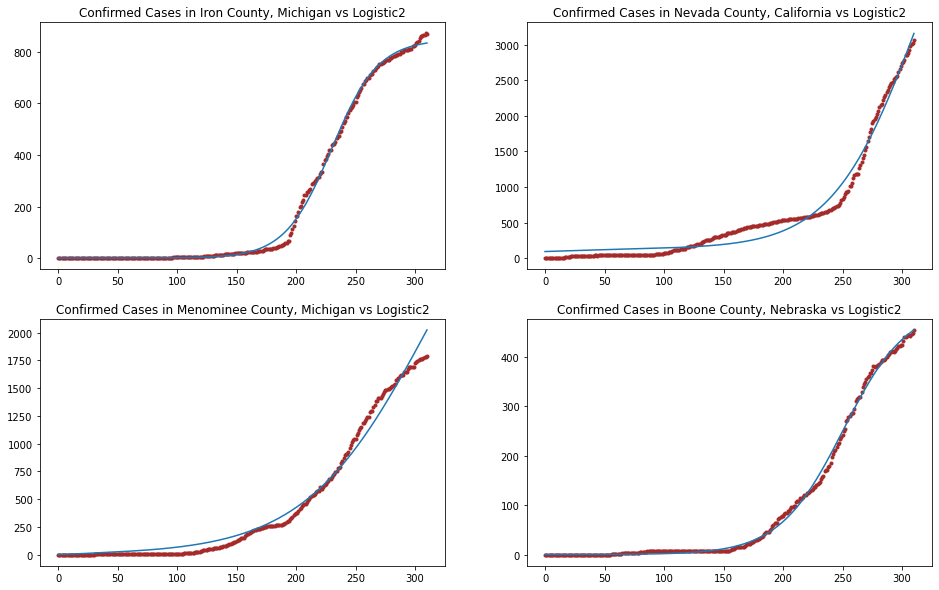

In [16]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

# Save the curves

Save the coefficients of the curves we just fit to disk, so that [`analyze_fit_us_data.ipynb`](analyze_fit_us_data.ipynb)
can reconstruct the curves and compare them to the underlying time series.

In [17]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02890810e+00 1.05865188e+00 1...,[ 120.93651921 122.59959556 124.28522475 125...,[ 292.32195481 293.87362835 295.43774197 297...
1003,Alabama,Baldwin,223234,996,6,[ 0 0 0 0 0 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03286738e+00 1.06681502e+00 1...,[ 309.19229746 313.69843924 318.2695372 ...,[ 261.45849414 265.54916839 269.70210067 ...
1005,Alabama,Barbour,24686,82,1,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02554080e+00 1.05173394e+00 1...,[ 53.05046486 53.97184563 54.90866787 55...,[ 535.15051762 510.83516795 483.84483444 454...
1007,Alabama,Bibb,22394,132,-1,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02597395e+00 1.05262255e+00 1...,[ 35.51783827 36.05415977 36.59850412 37...,[ 4.46272626 4.62196004 4.78678529 4...
1009,Alabama,Blount,57826,262,8,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02915025e+00 1.05915024e+00 1...,[1003.37136413 1007.57131097 1011.77144304 1015...,[ 277.27653155 277.56756596 277.87099457 278...
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02741758e+00 1.05558688e+00 1...,[8.13951787e-02 8.46996110e-02 8.81381918e-02 9...,[1.16617665e+00 1.21694183e+00 1.26986524e+00 1...
56039,Wyoming,Teton,23464,319,0,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02658197e+00 1.05387055e+00 1...,[ 15.69913956 15.99238784 16.29109612 16...,[ 13.4236463 13.75833627 14.1011814 14...
56041,Wyoming,Uinta,20226,126,1,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02535454e+00 1.05135193e+00 1...,[ 7.28969896 7.43631418 7.58587202 7...,[1.23356488e+00 1.36609614e+00 1.51064870e+00 1...


In [18]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               370   
      2020-03-11  Alabama  Autauga       55869               370   
      2020-03-12  Alabama  Autauga       55869               370   
      2020-03-13  Alabama  Autauga       55869               370   
      2020-03-14  Alabama  Autauga       55869               370   
...                   ...      ...         ...               ...   
56045 2021-01-10  Wyoming   Weston        6927               119   
      2021-01-11  Wyoming   Weston        6927               119   
      2021-01-12  Wyoming   Weston        6927               119   
      2021-01-13  Wyoming   Weston        6927               119   
      2021-01-14  Wyoming   Weston        6927               119   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              5          0              False     1.000000   
      2020-03-11              5          0              False     1.028908   
      2020-03-12              5          0              False     1.058652   
      2020-03-13              5          0              False     1.089255   
      2020-03-14              5          0              False     1.120744   
...                         ...        ...                ...          ...   
56045 2021-01-10              0        485              False   649.931947   
      2021-01-11              0        485              False   663.835180   
      2021-01-12              0        601              False   678.035827   
      2021-01-13              0        601              False   692.540253   
      2021-01-14              0        602              False   707.354955   

                    Logistic   Logistic2  
FIPS  Date                                
1001  2020-03-10  120.936519  292.321955  
      2020-03-11  122.599596  293.873628  
      2020-03-12  124.285225  295.437742  
      2020-03-13  125.993704  297.014509  
      2020-03-14  127.725334  298.604145  
...                      ...         ...  
56045 2021-01-10  484.631143  588.817464  
      2021-01-11  484.989198  596.115852  
      2021-01-12  485.323530  603.422226  
      2021-01-13  485.635681  610.734594  
      2021-01-14  485.927096  618.050957  

[952593 rows x 10 columns]

In [19]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [20]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,370,5,0.028498,0.0,9081.729294,0.013844,311.000000,957.512879,0.008021,18.742610,12051.465616,0.014809,310.373782,30.037952,300.858108
1003,Alabama,Baldwin,223234,996,6,0.032339,0.0,29503.984866,0.014623,311.000000,607.107601,1.890114,128.061738,40565.177296,0.013531,311.000000,55.766579,311.000000
1005,Alabama,Barbour,24686,82,1,0.025220,0.0,1619.102393,0.017807,190.093143,1342.659211,0.000000,0.000000,1450.216033,0.020795,174.553240,0.000000,4.629637
1007,Alabama,Bibb,22394,132,-1,0.025642,0.0,3954.603645,0.015124,311.000000,3796.743247,0.041013,153.445154,4166.904485,0.024963,311.000000,0.000000,105.055739
1009,Alabama,Blount,57826,262,8,0.028733,0.0,2025.916177,0.008293,2.282522,954.856238,0.000000,13.476428,14132.811596,0.016905,311.000000,0.000000,311.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,142,2,0.027048,0.0,4149.256730,0.039796,272.368290,2870.814090,0.047449,154.819069,3289.696300,0.070500,262.766287,35.131750,112.411493
56039,Wyoming,Teton,23464,319,0,0.026235,0.0,5066.600942,0.018565,311.000000,2228.964722,0.027079,163.224894,2516.468871,0.058188,261.015945,0.000000,232.321881
56041,Wyoming,Uinta,20226,126,1,0.025038,0.0,3619.410957,0.019954,311.000000,3035.365787,0.041856,311.000000,3618.609603,0.019944,311.000000,10.000022,20.000056


In [21]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
